<a href="https://colab.research.google.com/github/siva4iov/FlatsPrice_DS_Proj/blob/master/Predictions_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
!pip install geopandas
!pip install Shapely
import shapely
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [89]:
from google.colab import files
if not os.path.exists("/content/kazan.geojson"):
    files.upload()
if not os.path.exists("/content/dataset_clean_full.csv"):
    files.upload()

In [90]:
layer = gpd.read_file("kazan.geojson")

In [91]:
df = pd.read_csv("dataset_clean_full.csv", sep=";")
df.head()

,Living_space,Num_of_rooms,Renovation,Price,Total_area,Kitchen_area,Floor,Appliances_1,Appliances_2,Appliances_3,...,longitude,district_1,district_2,district_3,district_4,district_5,district_6,district_7,district_8,district_9
0,20.0,1,1,27000,39.0,12.0,10,0,1,0,...,49.179327,1,0,0,0,0,0,0,0,0
1,NaN,1,1,14000,18.0,NaN,9,0,0,0,...,49.107790,0,1,0,0,0,0,0,0,0
2,NaN,3,2,40000,105.0,25.0,2,0,1,1,...,49.169175,0,0,1,0,0,0,0,0,0
3,13.5,1,2,20000,45.0,17.5,5,0,1,1,...,49.136806,0,0,0,1,0,0,0,0,0
4,24.0,1,2,22000,36.0,6.0,10,0,1,1,...,49.146880,0,0,0,1,0,0,0,0,0


In [92]:
layer

,area,ref,url,name,access,amenity,fixme,is_in,koatuu,name:ar,...,official_status,official_name:ru,official_name:tyv,population:date,population:source,source:start_date,wikipedia:ru,wikipedia:uk,is_in:country_code,geometry
0,None,None,None,городской округ Казань,None,None,None,None,None,None,...,ru:городской округ,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((49.21169 55.92429, 49.21131 55..."


In [193]:
kazan_polygon = list(layer.geometry[0].geoms)[1]

In [210]:
from shapely.geometry import Polygon
from shapely.prepared import prep


def grid_bounds(geom, delta):
    minx, miny, maxx, maxy = geom.bounds
    nx = int((maxx - minx )/delta)
    ny = int((maxy - miny )/delta)
    gx, gy = np.linspace(minx,maxx,nx), np.linspace(miny,maxy,ny)
    grid = []
    for i in range(len(gx)-1):
        for j in range(len(gy)-1):
            poly_ij = Polygon([[gx[i],gy[j]],[gx[i],gy[j+1]],[gx[i+1],gy[j+1]],[gx[i+1],gy[j]]])
            grid.append( poly_ij )
    return grid


def partition(geom, delta):
    prepared_geom = prep(geom)
    grid = list(filter(prepared_geom.intersects, grid_bounds(geom, delta)))
    return grid

In [250]:
geom = kazan_polygon
grid = partition(geom, 0.03)

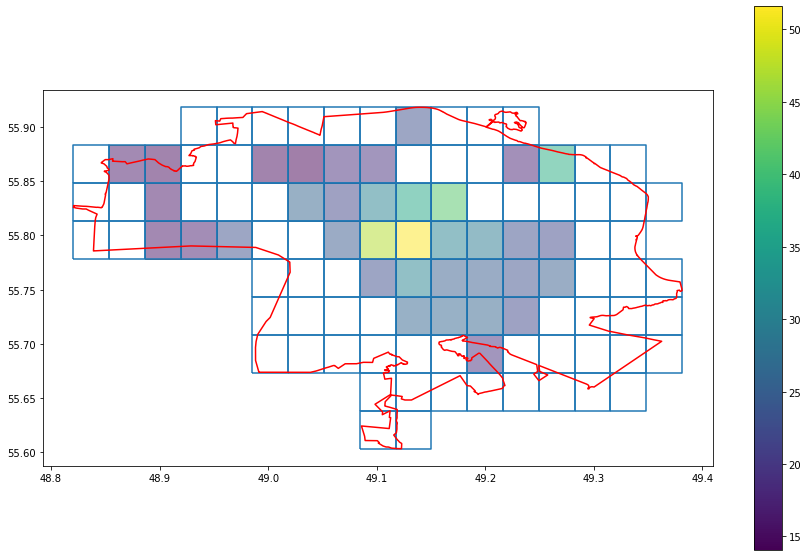

In [255]:


fig, ax = plt.subplots(figsize=(15, 10))
gpd.GeoSeries(grid).boundary.plot(ax=ax)
gpd.GeoSeries([geom]).boundary.plot(ax=ax,color="red")
gdf_p.plot(ax=ax, alpha=0.5, column='mean_price', legend=True, edgecolor="black")
plt.show()

In [253]:
from shapely.geometry import Point

def get_points(df):
  points = []
  values = np.concatenate([df.loc[:, ["longitude", "latitude"]].values,
                          df.index.values[np.newaxis].T], axis=1)
  for value in values:
    point = Point(value[0], value[1])
    ind = value[2]
    points.append((point, ind))
  return points

def get_polys(boundaries):
  boundaries = [np.array(value.coords) for value in boundaries]
  polys = [Polygon(value) for value in boundaries]
  return polys

def mean_for_polygon(df, points, polygons):
    mean_for_poly = []
    for polygon in polygons:
      pts_in_poly = [value[1] for value in points if polygon.contains(value[0])]
      means = df.loc[pts_in_poly]["Price"].mean()/1000
      # if pd.isna(means):
      #   means=0
      mean_for_poly.append(means)
    return mean_for_poly


In [254]:
points = get_points(df)
polys = get_polys(gpd.GeoSeries(grid).boundary)
mean_prices = mean_for_polygon(df, points, polys)
gdf_p = gpd.GeoDataFrame(np.concatenate([np.array(polys)[:, np.newaxis], np.array(mean_prices)[:, np.newaxis]], axis=1),
                         columns=["geometry", 'mean_price'])
gdf_p.loc[:, 'mean_price'] = gdf_p["mean_price"].astype(np.float64)

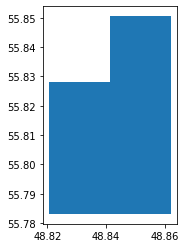

In [233]:
gpd.GeoSeries(polys[:5]).plot()

In [249]:

poi = Point(48.831349870370365, 55.79)
polys[0].centroid
ar = np.array(list(polys[0].boundary.coords))
width = ar[:, 0].max() - ar[:, 0].min()
height = ar[:, 1].max() - ar[:, 1].min()
width, height

(0.020765270370368683, 0.022458935714290362)

In [240]:
s = np.array(gpd.GeoSeries(grid).boundary[0].coords)
p1 = Polygon(s)
s = np.array(gpd.GeoSeries(grid).boundary[1].coords)
p2 = Polygon(s)
ts = gpd.GeoDataFrame([[p1,None],
                  [p2,5]], columns=["geometry", 'v'])
v = [[1], [5]]

In [98]:
coords = np.array(list(map(lambda x:np.array(x.coords), gpd.GeoSeries(grid).boundary.to_list()))).reshape(((210, 2)))

ValueError: ignored

In [ ]:
lat, lon = coords[:, 0], coords[:, 1]

In [153]:
np.array([1,2,3])[:, np.newaxis]

array([[1],
       [2],
       [3]])

In [147]:
df[df["Price"] == -1].mean()

Living_space     NaN
Num_of_rooms     NaN
Renovation       NaN
Price            NaN
Total_area       NaN
Kitchen_area     NaN
Floor            NaN
Appliances_1     NaN
Appliances_2     NaN
Appliances_3     NaN
Appliances_4     NaN
Appliances_5     NaN
Appliances_6     NaN
Appliances_7     NaN
Appliances_8     NaN
Appliances_9     NaN
Appliances_10    NaN
Balcony_1        NaN
Balcony_2        NaN
Furniture_1      NaN
Furniture_2      NaN
Furniture_3      NaN
Internet_tv_1    NaN
Internet_tv_2    NaN
Bathroom_1       NaN
Bathroom_2       NaN
Utilities_1      NaN
Room_type_1      NaN
Room_type_2      NaN
Studio           NaN
Floors_in_b      NaN
location         NaN
coord            NaN
latitude         NaN
longitude        NaN
district_1       NaN
district_2       NaN
district_3       NaN
district_4       NaN
district_5       NaN
district_6       NaN
district_7       NaN
district_8       NaN
district_9       NaN
dtype: object